In [0]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [0]:
# import fast ai
import fastai
# import fast ai vision and GAN modules
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Dataset
path = '/content/drive/My Drive/AugmenterDSet'
path_high = path+'/trainB'
path_low = path+'/trainA'

# Train Generator

In [0]:
# parameters
batch_size = 5
img_size = 400
architecture = models.resnet34
validation_pct = 0.1
validation_seed = 42
weight_decay = 1e-3
y_axis_range = (-3.,3.)
max_zoom_value=2.0

In [0]:
# set source
src = ImageImageList.from_folder(path_low).split_by_rand_pct(validation_pct, seed=validation_seed)

In [0]:
def get_preprocessed_data(batch_size,img_size):
    preprocessed_data = (src.label_from_func(lambda x: path_high+"/"+x.name)
           .transform(get_transforms(max_zoom=max_zoom_value), size=img_size, tfm_y=True)
           .databunch(bs=batch_size).normalize(imagenet_stats, do_y=True)
           )

    preprocessed_data.c = 3
    return preprocessed_data

In [0]:
data_generator = get_preprocessed_data(batch_size, img_size)
data_generator

ImageDataBunch;

Train: LabelList (1336 items)
x: ImageImageList
Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350)
y: ImageList
Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350)
Path: /content/drive/My Drive/AugmenterDSet/trainA;

Valid: LabelList (148 items)
x: ImageImageList
Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350)
y: ImageList
Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350)
Path: /content/drive/My Drive/AugmenterDSet/trainA;

Test: None

In [0]:
# Generator loss function
loss_generator = MSELossFlat()

In [0]:
# Generator Creating function
def create_generator_learner():
    return unet_learner(data_generator, architecture, wd=weight_decay, blur=True, norm_type=NormType.Weight,
                          self_attention=True, y_range=y_axis_range, loss_func=loss_generator)

In [0]:
# create generator
learn_generator = create_generator_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
# Find the best possible learning-rate
learn_generator.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


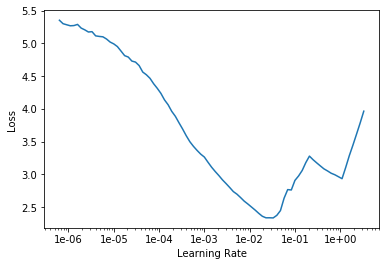

In [0]:
learn_generator.recorder.plot()

In [0]:
# train generator
learn_generator.fit_one_cycle(25, pct_start=0.8)

In [0]:
! mkdir /content/drive/'My Drive'/AugmenterDSet/generator
! ls -la '/content/drive/My Drive/AugmenterDSet'

mkdir: cannot create directory ‘/content/drive/My Drive/AugmenterDSet/generator’: File exists
total 20
drwx------ 2 root root 4096 Feb 29 12:37 discriminator
drwx------ 2 root root 4096 Feb 29 11:46 generator
drwx------ 2 root root 4096 Feb 29 11:47 image_gen
drwx------ 3 root root 4096 Feb 29 06:04 trainA
drwx------ 2 root root 4096 Feb 29 06:15 trainB


In [0]:
# export generator
learn_generator.export('/content/drive/My Drive/AugmenterDSet/generator/export.pkl')

In [0]:
# load generator
learn_generator = load_learner('/content/drive/My Drive/AugmenterDSet/generator/')

In [0]:
# unfreeze the model
learn_generator.unfreeze()

In [0]:
learn_generator.save('generator-pre2')

In [0]:
# paths for generated images by generator
name_generator = 'image_gen'
path_generator = path+"/"+name_generator

In [0]:
!mkdir '/content/drive/My Drive/AugmenterDSet/image_gen'
!ls '/content/drive/My Drive/AugmenterDSet/'

mkdir: cannot create directory ‘/content/drive/My Drive/AugmenterDSet/image_gen’: File exists
discriminator  generator  image_gen  trainA  trainB


In [0]:
def store_predicted_data(data_loader):
    i=0
    names = data_loader.dataset.items
    
    for batch_item in data_loader:
        # iterate predictions
        predictions = learn_generator.pred_batch(batch=batch_item, reconstruct=True)
        for o in predictions:
            o.save(path_generator+"/"+names[i].name)
            i += 1

In [0]:
# store generated images
store_predicted_data(data_generator.fix_dl)

# Train Discriminator





In [0]:
# reset the generator
learn_generator=None
gc.collect()

106

In [0]:
channels = 3

def get_discriminator_data(classes, batch_size, img_size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(validation_pct, seed=validation_seed)
    data_list = src.label_from_folder(classes=classes)
    discriminator_data = (data_list.transform(get_transforms(max_zoom=max_zoom_value), size=img_size)
           .databunch(bs=batch_size).normalize(imagenet_stats))
    discriminator_data.c = channels
    return discriminator_data

In [0]:
data_discriminator = get_discriminator_data([name_generator, 'trainB'], batch_size=batch_size, img_size=img_size)

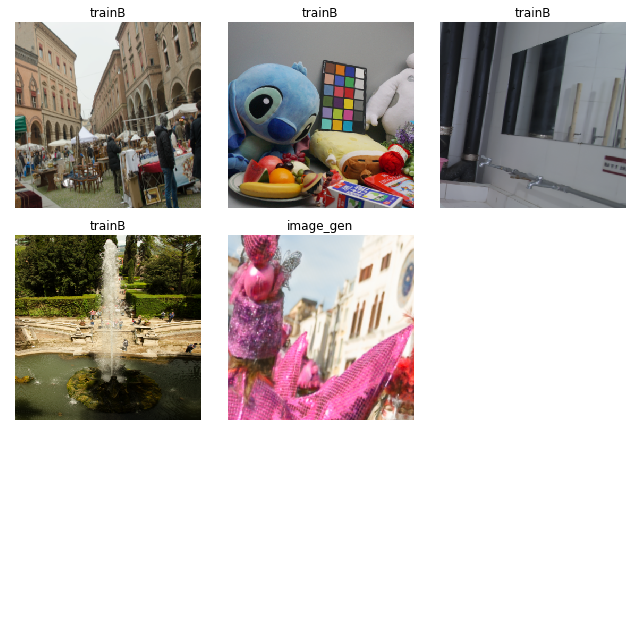

In [0]:
sample_rows = 3
data_discriminator.show_batch(rows=sample_rows, ds_type=DatasetType.Train, imgsize=3)

In [0]:
# Adaptive loss for the discriminator
loss_discriminator = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_discriminator_learner(dataset, metrics):
    return Learner(dataset, gan_critic(), metrics = metrics, loss_func = loss_discriminator, wd = weight_decay)

In [0]:
learn_discriminator = create_discriminator_learner(data_discriminator, accuracy_thresh_expand)

In [0]:
# Train the discriminator
num_of_epochs = 6
learning_rate = 1e-3

learn_discriminator.fit_one_cycle(num_of_epochs, learning_rate)

In [0]:
! mkdir /content/drive/'My Drive'/AugmenterDSet/discriminator
!ls -la '/content/drive/My Drive/AugmenterDSet'

mkdir: cannot create directory ‘/content/drive/My Drive/AugmenterDSet/discriminator’: File exists
total 20
drwx------ 2 root root 4096 Feb 29 12:37 discriminator
drwx------ 3 root root 4096 Mar  1 03:06 generator
drwx------ 2 root root 4096 Mar  1 03:17 image_gen
drwx------ 3 root root 4096 Feb 29 06:04 trainA
drwx------ 2 root root 4096 Feb 29 06:15 trainB


In [0]:
# Export discriminator
learn_discriminator.export('/content/drive/My Drive/AugmenterDSet/discriminator/export.pkl')

In [0]:
# load discriminator
learn_discriminator = load_learner('/content/drive/My Drive/AugmenterDSet/discriminator/')

In [0]:
learn_discriminator.save('critic-pre2')

# GAN

In [0]:
learn_discriminator=None
learn_generator=None
gc.collect()

22744

In [0]:
data_crit = get_discriminator_data(['trainA', 'trainB'], batch_size=batch_size, img_size=img_size)

In [0]:
learn_discriminator = create_discriminator_learner(data_crit, metrics=None).load('/content/drive/My Drive/AugmenterDSet/discriminator/models/critic-pre2')

In [0]:
learn_generator = create_generator_learner().load('/content/drive/My Drive/AugmenterDSet/generator/models/generator-pre2')

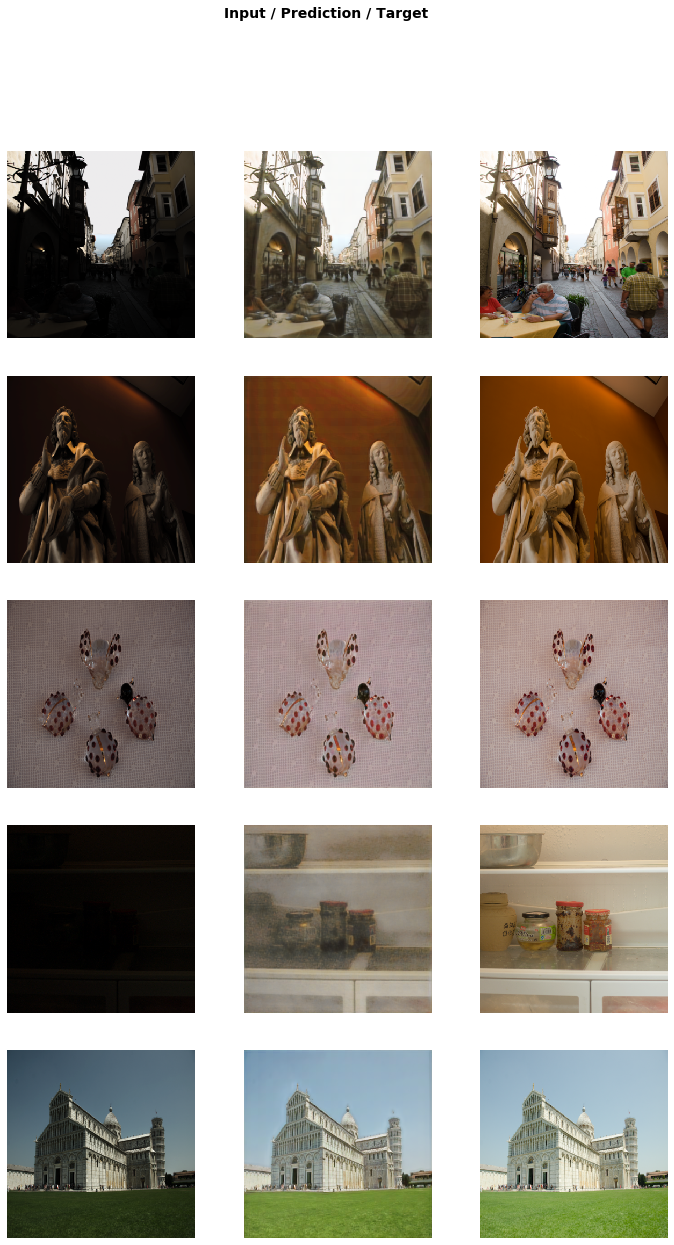

In [0]:
# without training gan
num_of_rows = 16
learn_generator.show_results(rows=num_of_rows)

In [0]:
# Switcher to handle generat0r and discriminator collaboration
switcher_threshold = 0.65
adaptive_switcher = partial(AdaptiveGANSwitcher, critic_thresh = switcher_threshold)
# GAN learner
learn = GANLearner.from_learners(learn_generator, learn_discriminator, weights_gen=(1.,50.), show_img=False, switcher=adaptive_switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=weight_decay)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-6

In [0]:
learn.fit(30,lr)

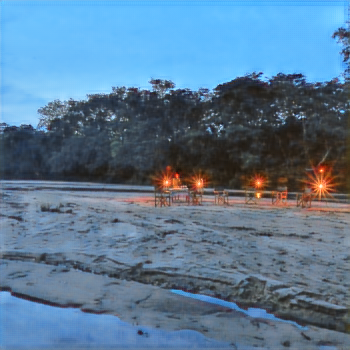

In [0]:
learn_gen.predict(open_image('./kumana.jpg'))[0]
# color deviations became low now

In [0]:
learn.save('gan-1c')

In [0]:
learn.data=get_data(16,192)

In [0]:
learn.fit(20,lr/2)

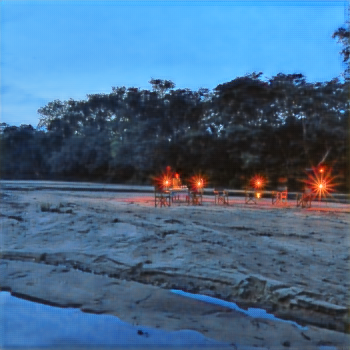

In [0]:
learn_gen.predict(open_image('./kumana.jpg'))[0]

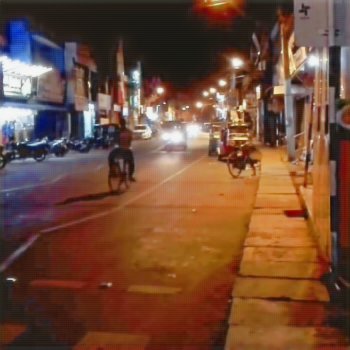

In [0]:
learn_gen.predict(open_image('./maxresdefault.jpg'))[0]

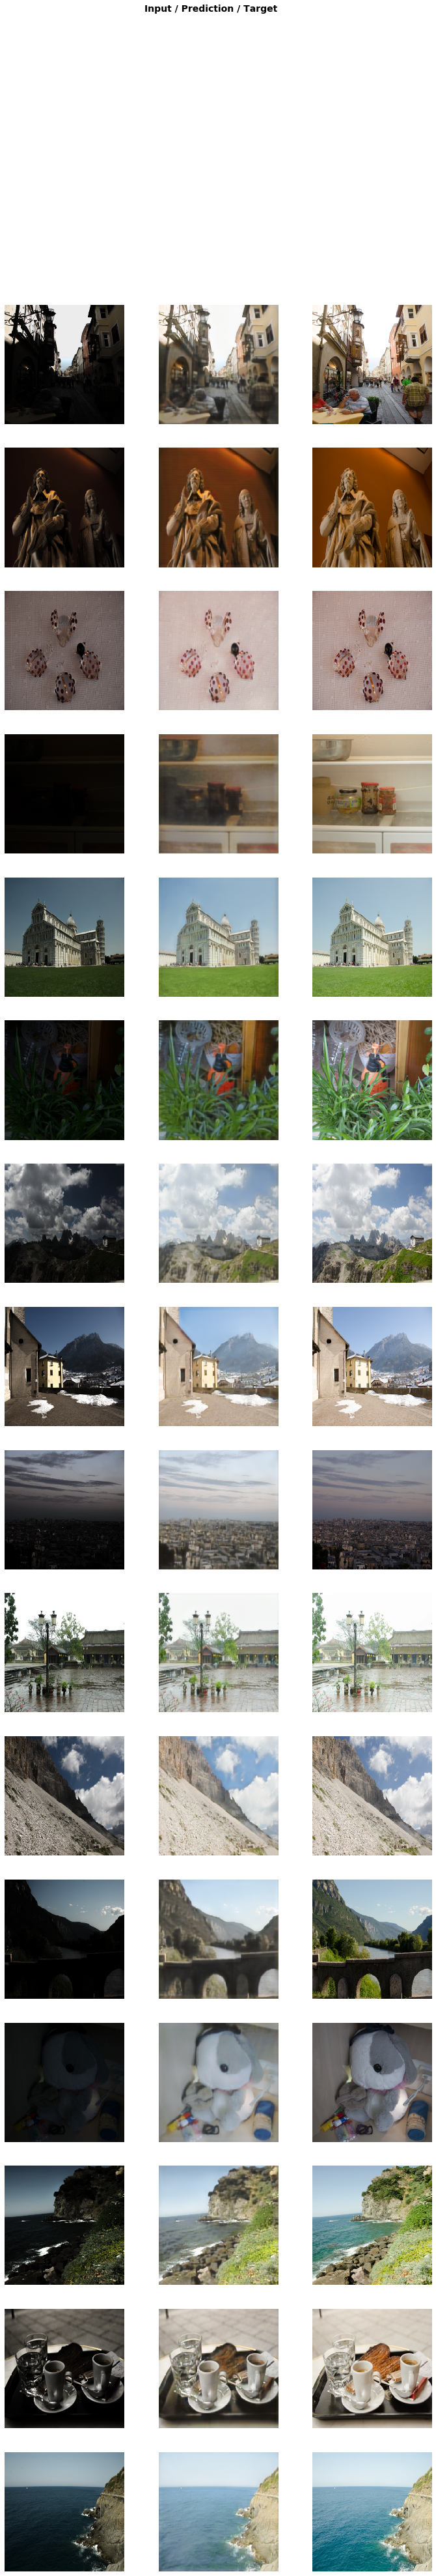

In [0]:
learn.show_results(rows=16)

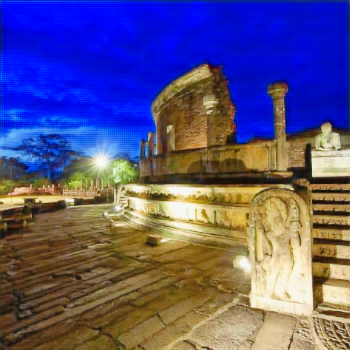

In [0]:
learn_gen.predict(open_image('./sl_landscape_1.jpg'))[0]

In [0]:
# Re-export generator
# AugmenterDSet
learn_gen.export('/content/drive/My Drive/AugmenterDSet/generator/export.pkl')

In [0]:
learn.save('gan-1c')

In [0]:
learn.load('gan-1c')

GANLearner(data=ImageDataBunch;

Train: LabelList (1336 items)
x: ImageImageList
Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192)
y: ImageList
Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192)
Path: /content/drive/My Drive/AugmenterDSet/trainA;

Valid: LabelList (148 items)
x: ImageImageList
Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192)
y: ImageList
Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192),Image (3, 192, 192)
Path: /content/drive/My Drive/AugmenterDSet/trainA;

Test: None, model=GANModule(
  (generator): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPoo

In [0]:
img = learn.predict(open_image('./lowlight_2.jpg'))[0]
img.save('lowlight_2_predicted.jpg')